In [222]:
# Generate plot for each dayin HB region 

import numpy as np 
import matplotlib
import cmocean
import cmocean.cm as cmo
import xarray as xr   
from pathlib import Path
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import warnings; warnings.simplefilter('ignore')
from functions import plot_cartopy
%matplotlib notebook
# input data directory
path = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc/')

# 2021
path2021 = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc-for-May-2021-06-02')

# region of interest
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Construct the full file name
fname = path / '{}.nc'.format(region)
fname2021 = path2021 / '{}.nc'.format(region) # 2021

### Load data into a `xarray.Dataset`:
# Note that the data is loaded lazily which means that no actual data are actually written
# into memory.
# ds = xr.open_dataset(fname, decode_times=False)
# ds2021 = xr.open_dataset(fname2021, decode_times=False)

ds = xr.open_dataset(fname)
ds2021 = xr.open_dataset(fname2021)

juld = ds.juld
juld2021 = ds2021.juld
# Combine data structures
juld = xr.concat([juld, juld2021], "juld")

# subset `xarray.Dataset` by index -- Labrador shelf only
ds = ds.isel(x=slice(1700, None), y=slice(700, 1450))
ds2021 = ds2021.isel(x=slice(1700, None), y=slice(700, 1450))

# create shortcuts to the variables. 
lon = ds.longitude
lat = ds.latitude
land = ds.land
# E_FA = ds['E_FA']

E_SAold = ds['E_SA']
E_SA2021 = ds2021['E_SA']

E_SA = xr.concat([E_SAold, E_SA2021], dim="juld")


## Use N_CT for concentration 
N_CTold = ds['N_CT']
N_CT2021 = ds2021['N_CT']
N_CT = xr.concat([N_CTold, N_CT2021], dim="juld")

# Replace ocean values with NaN
CT = xr.where(N_CT<10, np.nan, N_CT)

In [227]:
def plot_cartopy(ax, lon, lat):
    '''
    Set up the cartopy map with projection rotated so that Labrador coast is vertical. Input is the ax handle. 
    '''
    #Declare the land and ocean parameters
    LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
    edgecolor='dimgrey',
    facecolor=('dimgrey'),
    linewidth=1)
    OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
    facecolor='lightblue')
    # Set opacity to 0.5
    ax.background_patch.set_alpha(0.5)

    #Declare the lat and lon boundaries for the map and data
    domain = [99, 99, -99, -99]
    domain[0] = np.min(lat) # South
    domain[1] = np.min(lon) # West
    domain[2] = np.max(lat) # North
    domain[3] = np.max(lon) # East
#     domain = list(np.array(domain) + np.array([+1, +6, 0, -4]))
    domain = [54.5, -61.30979545701268, 62, -56.47452933956656]
    # domain = [55, -61.30979545701268, 59, -61]

    aoi_map = [domain[0], domain[2], domain[1], domain[3]]
#     # Plot results
#     transform = rot.transform_points(rot,lon,lat)
#     x_n = transform[...,0]
#     y_n = transform[...,1]

#     ax.add_feature(LAND_highres,zorder=1)
    ax.add_feature(OCEAN_highres,zorder=1)
    ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
#     ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)
    

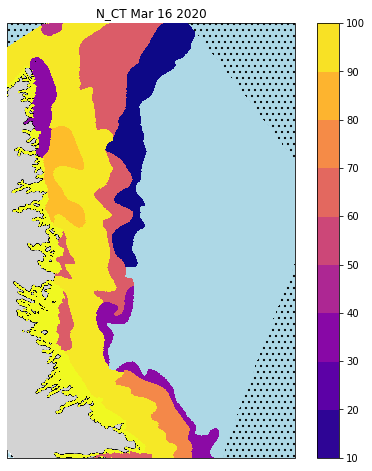

In [229]:
%matplotlib inline
dd = 1010
# cmap='YlGnBu_r'
cmap='plasma'
# cmap='rainbow'

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection=rot)
plot_cartopy(ax,lon,lat)
plt.fill_between([0,100000],[0,100000], color="none", hatch="..", edgecolor="k", linewidth=0.0,transform=ccrs.PlateCarree(),zorder=4)
# Plot land
# plt.contourf(x_n,y_n,hatched[j,:,:],levels=1, hatches=['//', ''],  alpha=0.,transform=ccrs.PlateCarree(),zorder=5)
plt.pcolormesh(lon,lat,land,transform=ccrs.PlateCarree(),zorder=4,cmap = matplotlib.colors.ListedColormap(['lightblue', 'lightgrey']))
# plot coastline
plt.contour(lon,lat,land,colors='black',transform=ccrs.PlateCarree(),zorder=4)
# Plot ice concentration 
CS = plt.pcolormesh(lon,lat,CT[dd],transform=ccrs.PlateCarree(),cmap=cmap,zorder=4)
plt.title('N_CT ' + juld.dt.strftime("%b %d %Y").values[dd])
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(N_CT[dd])
m.set_clim(10., 100.)
plt.colorbar(m,boundaries=np.linspace(10, 100, 10))


In [107]:
np.unique(N_CT[dd])[:15]

array([  0.,   2.,  30.,  50.,  60.,  70.,  80.,  90.,  97., 100.,  nan,
        nan,  nan,  nan,  nan])